In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('./data/second_innings.csv')
df

,match_id,venue,innings,ball,batting_team,bowling_team,runs_off_bat,extras,wides,noballs,byes,legbyes,wicket_type,runs_required,wickets_remaining,balls_remaining,crr,rrr,winner
0,1283048,Gahanga International Cricket Stadium. Rwanda,2,0.1,Mozambique,Botswana,0,0,NaN,NaN,NaN,NaN,caught,153.0,9.0,119.0,0.00,7.71,0.0
1,1283048,Gahanga International Cricket Stadium. Rwanda,2,0.2,Mozambique,Botswana,0,0,NaN,NaN,NaN,NaN,NaN,153.0,9.0,118.0,0.00,7.78,0.0
2,1283048,Gahanga International Cricket Stadium. Rwanda,2,0.3,Mozambique,Botswana,1,0,NaN,NaN,NaN,NaN,NaN,152.0,9.0,117.0,2.00,7.79,0.0
3,1283048,Gahanga International Cricket Stadium. Rwanda,2,0.4,Mozambique,Botswana,0,0,NaN,NaN,NaN,NaN,NaN,152.0,9.0,116.0,1.50,7.86,0.0
4,1283048,Gahanga International Cricket Stadium. Rwanda,2,0.5,Mozambique,Botswana,0,0,NaN,NaN,NaN,NaN,NaN,152.0,9.0,115.0,1.20,7.93,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232390,1384584,Marsa Sports Club,2,19.2,Luxembourg,Malta,1,0,NaN,NaN,NaN,NaN,NaN,68.0,1.0,4.0,6.62,102.00,0.0
232391,1384584,Marsa Sports Club,2,19.3,Luxembourg,Malta,2,0,NaN,NaN,NaN,NaN,NaN,66.0,1.0,3.0,6.67,132.00,0.0
232392,1384584,Marsa Sports Club,2,19.4,Luxembourg,Malta,2,0,NaN,NaN,NaN,NaN,NaN,64.0,1.0,2.0,6.71,192.00,0.0
232393,1384584,Marsa Sports Club,2,19.5,Luxembourg,Malta,1,0,NaN,NaN,NaN,NaN,NaN,63.0,1.0,1.0,6.71,378.00,0.0


In [3]:
df.drop(columns=['venue', 'innings', 'ball', 'batting_team', 'bowling_team', 'runs_off_bat', 'extras', 'wides', 'noballs', 'byes', 'legbyes', 'wicket_type'], inplace=True)
df.head()

,match_id,runs_required,wickets_remaining,balls_remaining,crr,rrr,winner
0,1283048,153.0,9.0,119.0,0.0,7.71,0.0
1,1283048,153.0,9.0,118.0,0.0,7.78,0.0
2,1283048,152.0,9.0,117.0,2.0,7.79,0.0
3,1283048,152.0,9.0,116.0,1.5,7.86,0.0
4,1283048,152.0,9.0,115.0,1.2,7.93,0.0


In [4]:
df.isna().sum()

match_id                0
runs_required           0
wickets_remaining       0
balls_remaining         0
crr                     0
rrr                     0
winner               3482
dtype: int64

In [5]:
df.dropna(inplace=True)

In [6]:
df.isna().sum()

match_id             0
runs_required        0
wickets_remaining    0
balls_remaining      0
crr                  0
rrr                  0
winner               0
dtype: int64

In [7]:
df.shape

(228913, 7)

In [8]:
df['runs_required'] = df['runs_required'].astype('int')
df['wickets_remaining'] = df['wickets_remaining'].astype('int')
df['balls_remaining'] = df['balls_remaining'].astype('int')
df['winner'] = df['winner'].astype('int')

In [9]:
df.head()

,match_id,runs_required,wickets_remaining,balls_remaining,crr,rrr,winner
0,1283048,153,9,119,0.0,7.71,0
1,1283048,153,9,118,0.0,7.78,0
2,1283048,152,9,117,2.0,7.79,0
3,1283048,152,9,116,1.5,7.86,0
4,1283048,152,9,115,1.2,7.93,0


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fast')

## Outlier Analysis

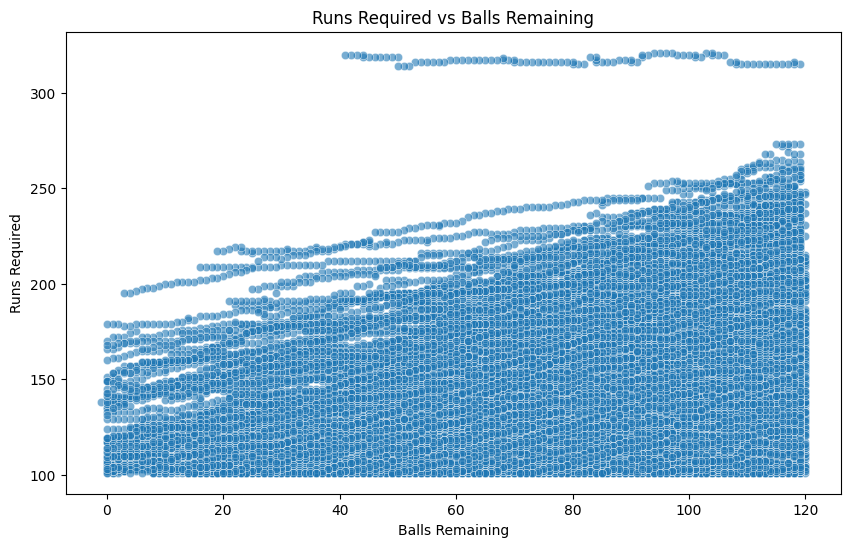

In [13]:
# scatter plot for runs required with minimum runs 100 vs balls remaining
plt.figure(figsize=(10, 6))
sns.scatterplot(x='balls_remaining', y='runs_required', data=df[(df['runs_required'] > 100)], alpha=0.6)
plt.title('Runs Required vs Balls Remaining')
plt.xlabel('Balls Remaining')
plt.ylabel('Runs Required')
plt.show()

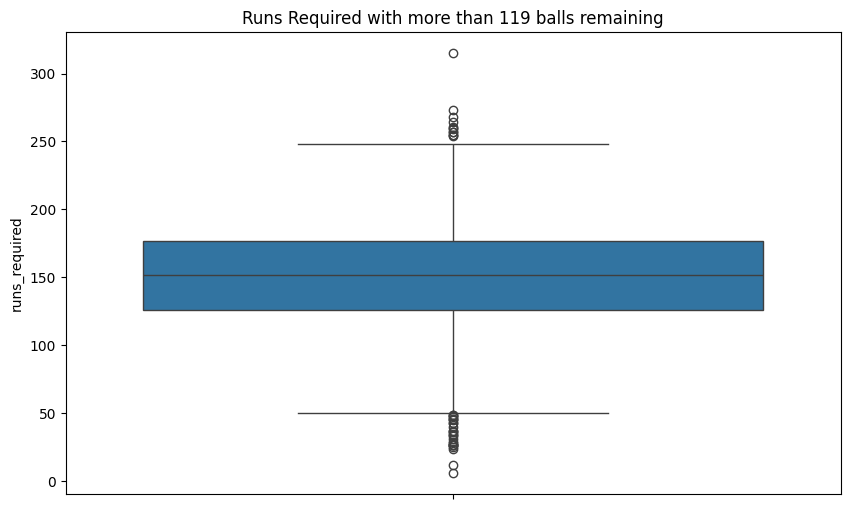

In [14]:
# boxplot for runs remaining with more than 119 balls remaining
plt.figure(figsize=(10, 6))
sns.boxplot(y='runs_required', data=df[(df['balls_remaining'] >= 119)])
plt.title('Runs Required with more than 119 balls remaining')
plt.show()

In [15]:
# get q1, q2, q3 for runs remaining with more than 119 balls remaining
q1 = df[(df['balls_remaining'] >= 119)]['runs_required'].quantile(0.25)
q2 = df[(df['balls_remaining'] >= 119)]['runs_required'].quantile(0.5)
q3 = df[(df['balls_remaining'] >= 119)]['runs_required'].quantile(0.75)

print(f'Q1: {q1}, Q2: {q2}, Q3: {q3}')

iqr = q3 - q1

# get lower and upper bounds
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

print(f'Lower Bound: {lower_bound}, Upper Bound: {upper_bound}')

Q1: 126.0, Q2: 152.0, Q3: 177.0
Lower Bound: 49.5, Upper Bound: 253.5


In [16]:
# find match_id for outliers accordingly
outliers = df[(df['balls_remaining'] >= 119)][(df['runs_required'] < lower_bound) | (df['runs_required'] > upper_bound)]

outlier_matches = outliers['match_id'].unique()

outlier_matches

/var/folders/4b/7z2zxbbs003f03_9ln3mqtth0000gn/T/ipykernel_70718/3550993586.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers = df[(df['balls_remaining'] >= 119)][(df['runs_required'] < lower_bound) | (df['runs_required'] > upper_bound)]


array([1322001, 1168113, 1320974, 1200425, 1354803, 1176796, 1273723,
       1322003, 1307478, 1332506, 1399104, 1283030, 1343749, 1418543,
        682933, 1418541, 1184901, 1343756,  287860, 1383103, 1299577,
        995467, 1383101, 1343763, 1373582, 1403305, 1122730, 1339605,
       1400988, 1310177, 1343760])

In [17]:
df[df['match_id'].isin(outlier_matches)]

,match_id,runs_required,wickets_remaining,balls_remaining,crr,rrr,winner
7807,1322001,31,9,119,0.00,1.56,1
7808,1322001,31,9,118,0.00,1.58,1
7809,1322001,31,9,117,0.00,1.59,1
7810,1322001,30,9,116,1.50,1.55,1
7811,1322001,29,9,115,2.40,1.51,1
...,...,...,...,...,...,...,...
224364,1343760,6,10,102,10.67,0.35,1
224365,1343760,4,10,101,10.74,0.24,1
224366,1343760,4,10,100,10.20,0.24,1
224367,1343760,3,10,99,10.00,0.18,1


In [18]:
# drop where match id is in outlier_matches
df = df[~df['match_id'].isin(outlier_matches)]
df

,match_id,runs_required,wickets_remaining,balls_remaining,crr,rrr,winner
0,1283048,153,9,119,0.00,7.71,0
1,1283048,153,9,118,0.00,7.78,0
2,1283048,152,9,117,2.00,7.79,0
3,1283048,152,9,116,1.50,7.86,0
4,1283048,152,9,115,1.20,7.93,0
...,...,...,...,...,...,...,...
232390,1384584,68,1,4,6.62,102.00,0
232391,1384584,66,1,3,6.67,132.00,0
232392,1384584,64,1,2,6.71,192.00,0
232393,1384584,63,1,1,6.71,378.00,0


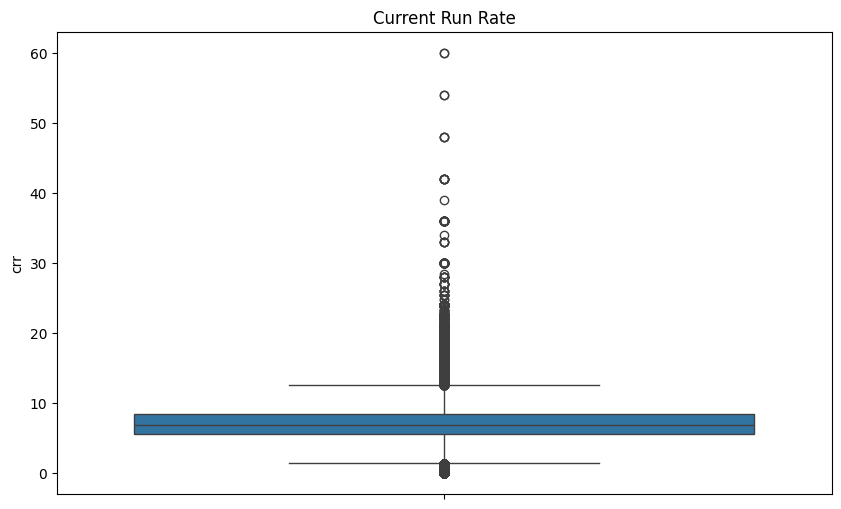

In [19]:
# boxplot for current run rate
plt.figure(figsize=(10, 6))
sns.boxplot(y='crr', data=df)
plt.title('Current Run Rate')
plt.show()

In [20]:
# get q1, q2, q3 for current run rate
q1 = df['crr'].quantile(0.25)
q2 = df['crr'].quantile(0.5)
q3 = df['crr'].quantile(0.75)

print(f'Q1: {q1}, Q2: {q2}, Q3: {q3}')

iqr = q3 - q1

# get lower and upper bounds
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

print(f'Lower Bound: {lower_bound}, Upper Bound: {upper_bound}')

Q1: 5.585, Q2: 6.94, Q3: 8.4
Lower Bound: 1.3624999999999998, Upper Bound: 12.6225


In [21]:
# remove outliers
df = df[(df['crr'] > lower_bound) & (df['crr'] < upper_bound)]

print(df['crr'].min())
print(df['crr'].max())

1.38
12.62


In [22]:
# sort df by rrr
df.sort_values(by='rrr', ascending=True).head()

,match_id,runs_required,wickets_remaining,balls_remaining,crr,rrr,winner
1395,1321465,138,3,-1,6.20,-828.0,0
50271,1384593,62,1,-1,7.24,-372.0,0
171165,1344794,59,4,-1,6.10,-354.0,0
171038,412699,0,5,0,8.35,0.0,1
191911,1384590,0,6,14,7.87,0.0,1


In [23]:
# remove values where balls remaining is less than 0
df = df[df['balls_remaining'] >= 0]

In [24]:
df['rrr'].min()

0.0

In [25]:
df.sort_values(by='rrr', ascending=False).head(15)

,match_id,runs_required,wickets_remaining,balls_remaining,crr,rrr,winner
143522,1321272,179,3,0,2.20,1074.0,0
143521,1321272,179,3,1,2.22,1074.0,0
60987,1176792,172,2,1,4.08,1032.0,0
60988,1176792,170,2,0,4.15,1020.0,0
147286,1286670,168,5,1,4.49,1008.0,0
147287,1286670,168,4,0,4.45,1008.0,0
72425,1321998,166,2,0,2.90,996.0,0
72424,1321998,166,2,1,2.92,996.0,0
50140,1208606,161,4,1,4.74,966.0,0
50141,1208606,160,4,0,4.75,960.0,0


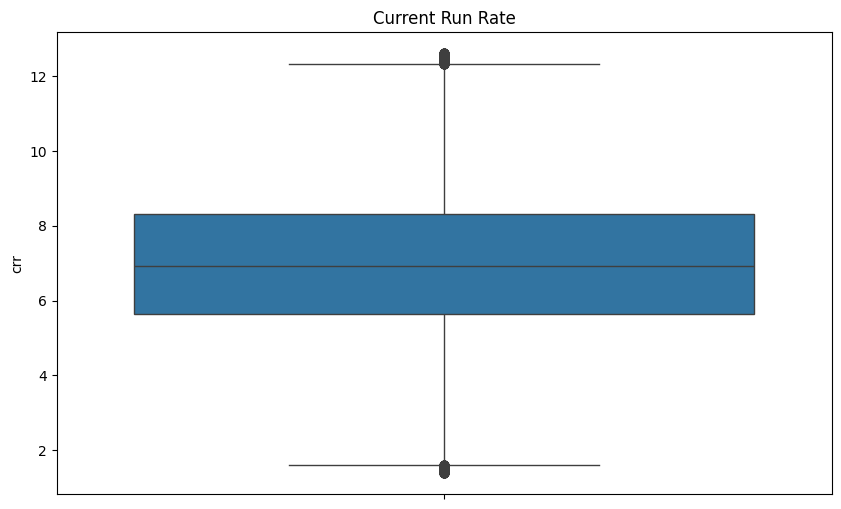

In [26]:
# boxplot for required run rate
plt.figure(figsize=(10, 6))
sns.boxplot(y='crr', data=df)
plt.title('Current Run Rate')
plt.show()

In [27]:
# get q1, q2, q3 for required run rate
q1 = df['rrr'].quantile(0.25)
q2 = df['rrr'].quantile(0.5)
q3 = df['rrr'].quantile(0.75)

print(f'Q1: {q1}, Q2: {q2}, Q3: {q3}')

iqr = q3 - q1

# get lower and upper bounds
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

print(f'Lower Bound: {lower_bound}, Upper Bound: {upper_bound}')

Q1: 7.14, Q2: 9.38, Q3: 12.67
Lower Bound: -1.1550000000000002, Upper Bound: 20.965


In [28]:
df[df['rrr'] > upper_bound].shape

(19656, 7)

In [29]:
df = df[(df['rrr'] > lower_bound) & (df['rrr'] < upper_bound)]

In [30]:
df['rrr'].max()

20.95

In [31]:
df.shape

(198943, 7)

## Model Building

In [32]:
# preprocessing for model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X = df[['runs_required', 'wickets_remaining', 'crr', 'rrr', 'balls_remaining']]
# X = df[['runs_required', 'wickets_remaining', 'balls_remaining']]
y = df['winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [33]:
# logistic regression model
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

In [34]:
accuracy = lr_model.score(X_test, y_test)
accuracy

0.8103998592575837

In [35]:
print(X_test[10])
lr_model.predict_proba(X_test)[10]

[0.56       1.         0.94483986 0.34272076 0.975     ]


array([0.21338072, 0.78661928])

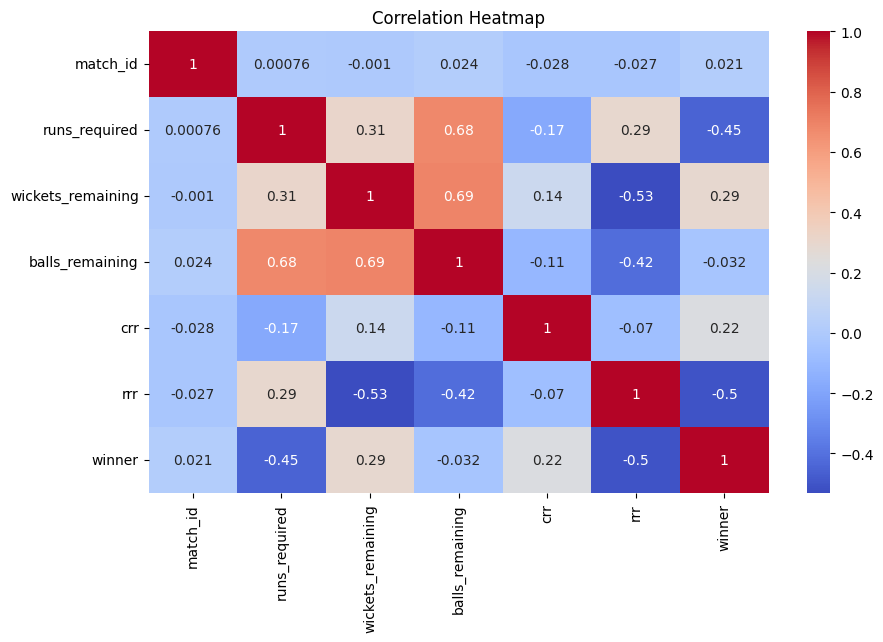

In [36]:
# correlation
corr = df.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [37]:
# test for custom input
custom_data = [193, 10, 7, 9.8135593220, 118]
# custom_data = [10, 1, 5, 2.4, 1]

# scale custom data
custom_data = scaler.transform([custom_data])

print(lr_model.predict(custom_data))

batting_team_probability = lr_model.predict_proba(custom_data)[0][1]
bowling_team_probability = lr_model.predict_proba(custom_data)[0][0]

print(f'Batting Team Probability: {batting_team_probability}')
print(f'Bowling Team Probability: {bowling_team_probability}')

[0]
Batting Team Probability: 0.10612565719800804
Bowling Team Probability: 0.893874342801992


/Users/omkamath/Documents/Personal Project/t20-winner-prediction/.venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [38]:
import pickle
import joblib

In [39]:
joblib.dump(scaler, './models/scaler.pkl')

['./models/scaler.pkl']

In [41]:
# load the scaler
scaler = joblib.load('./models/scaler.pkl')

# test on custom data
test_data = [[100, 5, 10, 10, 100]]
test_data = scaler.transform(test_data)

test_data

/Users/omkamath/Documents/Personal Project/t20-winner-prediction/.venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


array([[0.4       , 0.5       , 0.76690391, 0.47732697, 0.83333333]])

### Test model over ranges of overs

In [42]:
# make a function for above 5 cells
def get_accuracy(model, data):
    X = data[['runs_required', 'wickets_remaining', 'crr', 'rrr', 'balls_remaining']]
    y = data['winner']

    X = scaler.transform(X)

    accuracy = model.score(X, y)
    return accuracy

def test_over_overs(model):
    first_5_overs = df[(df['balls_remaining'] >= 90)].copy()
    overs_5_10 = df[(df['balls_remaining'] >= 60) & (df['balls_remaining'] < 90)].copy()
    overs_10_15 = df[(df['balls_remaining'] >= 30) & (df['balls_remaining'] < 60)].copy()
    overs_15_20 = df[(df['balls_remaining'] < 30)].copy()

    first_5_overs_accuracy = get_accuracy(model, first_5_overs)
    overs_5_10_accuracy = get_accuracy(model, overs_5_10)
    overs_10_15_accuracy = get_accuracy(model, overs_10_15)
    overs_15_20_accuracy = get_accuracy(model, overs_15_20)

    return first_5_overs_accuracy, overs_5_10_accuracy, overs_10_15_accuracy, overs_15_20_accuracy

In [47]:
#write test_over_overs for 4 overs instead of 5

def test_over_overs_4(model):
    first_4_overs = df[(df['balls_remaining'] >= 96)].copy()
    overs_4_8 = df[(df['balls_remaining'] >= 72) & (df['balls_remaining'] < 96)].copy()
    overs_8_12 = df[(df['balls_remaining'] >= 48) & (df['balls_remaining'] < 72)].copy()
    overs_12_16 = df[(df['balls_remaining'] >= 24) & (df['balls_remaining'] < 48)].copy()
    overs_16_20 = df[(df['balls_remaining'] < 24)].copy()

    first_4_overs_accuracy = get_accuracy(model, first_4_overs)
    overs_4_8_accuracy = get_accuracy(model, overs_4_8)
    overs_8_12_accuracy = get_accuracy(model, overs_8_12)
    overs_12_16_accuracy = get_accuracy(model, overs_12_16)
    overs_16_20_accuracy = get_accuracy(model, overs_16_20)

    return first_4_overs_accuracy, overs_4_8_accuracy, overs_8_12_accuracy, overs_12_16_accuracy, overs_16_20_accuracy

In [46]:
acc_0_5, acc_5_10, acc_10_15, acc_15_20 = test_over_overs_4(lr_model)

print(f'First  Overs Accuracy: {acc_0_5}')
print(f'5-10 Overs Accuracy: {acc_5_10}')
print(f'10-15 Overs Accuracy: {acc_10_15}')
print(f'15-20 Overs Accuracy: {acc_15_20}')

First 5 Overs Accuracy: 0.7510593683106898
5-10 Overs Accuracy: 0.8049039872981636
10-15 Overs Accuracy: 0.845451845006271
15-20 Overs Accuracy: 0.8258342053249622


In [48]:
acc_0_4, acc_4_8, acc_8_12, acc_12_16, acc_16_20 = test_over_overs_4(lr_model)

print(f'First 4 Overs Accuracy: {acc_0_4}')
print(f'4-8 Overs Accuracy: {acc_4_8}')
print(f'8-12 Overs Accuracy: {acc_8_12}')
print(f'12-16 Overs Accuracy: {acc_12_16}')
print(f'16-20 Overs Accuracy: {acc_16_20}')

First 4 Overs Accuracy: 0.7510593683106898
4-8 Overs Accuracy: 0.7992400883248125
8-12 Overs Accuracy: 0.8306526734148917
12-16 Overs Accuracy: 0.8531840205675862
16-20 Overs Accuracy: 0.8109121788974595


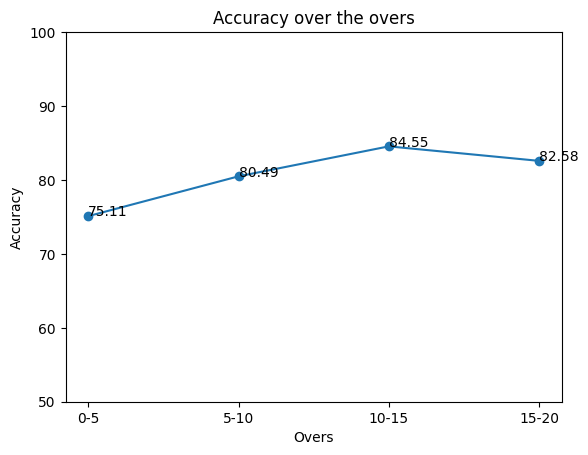

In [51]:
x = ['0-5', '5-10', '10-15', '15-20']
y = [acc_0_5 * 100, acc_5_10 * 100, acc_10_15 * 100, acc_15_20 * 100]

plt.plot(x, y, marker='o')
plt.ylim(50, 100)
plt.title('Accuracy over the overs')
plt.xlabel('Overs')
for i in range(len(x)):
    plt.text(x[i], y[i], round(y[i],2))
plt.ylabel('Accuracy')
plt.show()

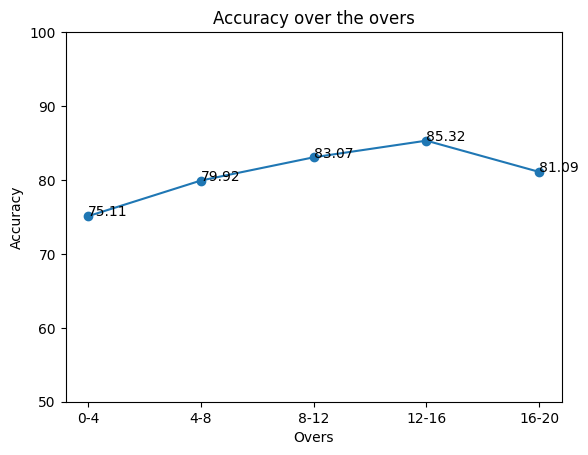

In [52]:
#Plot for 4 overs
x = ['0-4', '4-8', '8-12', '12-16', '16-20']
y = [acc_0_4 * 100, acc_4_8 * 100, acc_8_12 * 100, acc_12_16 * 100, acc_16_20 * 100]

plt.plot(x, y, marker='o')
plt.ylim(50, 100)
plt.title('Accuracy over the overs')
plt.xlabel('Overs')
for i in range(len(x)):
    plt.text(x[i], y[i], round(y[i],2))
plt.ylabel('Accuracy')
plt.show()

In [ ]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

In [ ]:
rf_classifier.score(X_test, y_test)

## Feedforward Neural Network with 1 hidden layer

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2

In [ ]:
# predict
y_pred = fnn_1l_model.predict(X_test)

loss, accuracy = fnn_1l_model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

In [ ]:
# test for custom input
# custom_data = [10, 5, 60, 1]
custom_data = [70, 8, 6, 8.4, 50]

# scale custom data
custom_data = scaler.transform([custom_data])

batting_team_probability = fnn_1l_model.predict(custom_data)[0][0]
bowling_team_probability = 1 - batting_team_probability

print(f'Batting Team Probability: {batting_team_probability}')
print(f'Bowling Team Probability: {bowling_team_probability}')

In [ ]:
fnn_2l_model = Sequential()

fnn_2l_model.add(Dense(4, activation='tanh'))
fnn_2l_model.add(Dense(64, activation='tanh'))
fnn_2l_model.add(Dense(32, activation='tanh'))
fnn_2l_model.add(Dense(1, activation='sigmoid'))

fnn_2l_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

fnn_2l_model.fit(X_train, y_train, epochs=10, verbose=1)

In [ ]:
# predict
y_pred = fnn_2l_model.predict(X_test)

loss, accuracy = fnn_2l_model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')